In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, median_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Deep Learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

#### Functions for testing

In [200]:
def calculate_smape(y_true, y_pred):
    '''
    Calculate the smape which is the percentage of: average of (absolute difference between y_pred and y_test) / (average value of y_pred,y_test)

    Params:
    y_true: the real values of the dataset
    y_pred: the predictions of our model
    '''
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    
    zero_indexes = denominator == 0
    
    valid_entries = ~zero_indexes
    if not np.any(valid_entries):
        return 0.0
    
    smape_values = 2 * numerator[valid_entries] / denominator[valid_entries] * 100
    return np.mean(smape_values)
    
def test(model, X_test_, y_test_, y_pred=None):
    '''
    We test our model and print various metrics for comparison

    Params:
    model: to test
    X_test: which are features to test
    y_test: the real values that match X_test
    '''
    if y_pred is None:
        y_pred = model.predict(X_test_)
    
    rmse = root_mean_squared_error(y_test_, y_pred)
    mae = mean_absolute_error(y_test_, y_pred)
    mse = mean_squared_error(y_test_, y_pred)
    mabse = median_absolute_error(y_test_, y_pred)
    r2 = r2_score(y_test_, y_pred)
    smape = calculate_smape(y_test_, y_pred)

    print(f"Root mean Squared Error: {rmse:.4f}")
    print(f"Mean absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Median absolute Error: {mabse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"sMAPE: {smape:.4f}")

    return y_pred

def visualize(y_test, y_pred):
    '''
    Params:
    y_test: the real values that match X_test
    y_pred: the models predicted y values
    '''
    plt.scatter(y_test, y_pred, alpha=0.3)  # alpha=0.3 for semi-transparent dots
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # red diagonal line
    plt.xlabel("Actual Comment Volume")
    plt.ylabel("Predicted Comment Volume")
    plt.title("Actual vs Predicted Comment Volume")
    plt.show()

## Experiements
#### Option 1: Train and test without any data preprocessing or feature engineering

In [201]:
columns = ['Page Popularity/likes', 'Page Checkins', 'Page talking about', 'Page Category', 'Derived Feature 5', 'Derived Feature 6', 'Derived Feature 7', 
    'Derived Feature 8', 'Derived Feature 9', 'Derived Feature 10', 'Derived Feature 11', 'Derived Feature 12', 'Derived Feature 13', 
    'Derived Feature 14', 'Derived Feature 15', 'Derived Feature 16', 'Derived Feature 17', 'Derived Feature 18', 'Derived Feature 19', 'Derived Feature 20', 
    'Derived Feature 21', 'Derived Feature 22', 'Derived Feature 23', 'Derived Feature 24', 'Derived Feature 25', 'Derived Feature 26', 'Derived Feature 27', 
    'Derived Feature 28', 'Derived Feature 29', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'Base time', 'Post length', 'Post Share Count', 'Post Promotion Status',
    'H Local', 'Post Published Sunday', 'Post Published Monday', 'Post Published Tuesday',  'Post Published Wednesday', 'Post Published Thursday', 
    'Post Published Friday', 'Post Published Saturday', 'Base DateTime Sunday', 'Base DateTime Monday', 'Base DateTime Tuesday','Base DateTime Wednesday', 
    'Base DateTime Thursday', 'Base DateTime Friday', 'Base DateTime Saturday', 'Target Variable' ]

base_training1 = pd.read_csv('./Dataset/Training/Features_Variant_1.csv', sep=',', header=None, names=columns)
base_training2 = pd.read_csv('./Dataset/Testing/Features_TestSet.csv', sep=',', header=None, names=columns)

base_training_complete = pd.concat([base_training1, base_training2])
base_training_complete.shape

(50993, 54)

In [202]:
'''
The .values changes type from pandas to a numpy array, it strips the labels of rows and columns
'''
base_X = base_training_complete.iloc[:, :-1]
base_y = base_training_complete.iloc[:, -1]

base_X_np = base_training_complete.iloc[:, :-1].values # Independent variables - the features.
base_y_np = base_training_complete.iloc[:, -1].values # dependent variable - prediction

In [203]:
base_X_train, base_X_test, base_y_train, base_y_test = train_test_split(base_X_np, base_y_np, test_size = 0.3, random_state = 1) # 30% for testing dataset

In [204]:
base_lin_regression = LinearRegression()
base_lin_regression.fit(base_X_train, base_y_train)  # lec 4, slide 46 - uses normal equations since we have a small/medium-sized dataset

LinearRegression()

In [205]:
base_y_pred = test(base_lin_regression, base_X_test, base_y_test)

Root mean Squared Error: 45.8769
Mean absolute Error: 14.1815
Mean Squared Error: 2104.69
Median absolute Error: 7.2876
R² Score: 0.2482
sMAPE: 156.7407


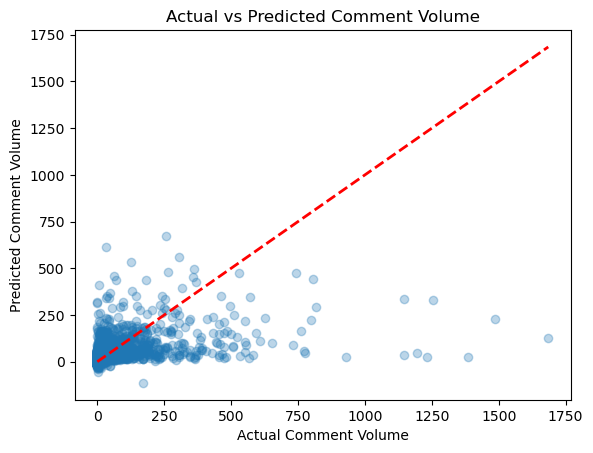

In [206]:
visualize(base_y_test, base_y_pred)

#### Option 2: Apply basic preprocessing: drop duplicates, drop column that has only zeros

In [207]:
preprocess_training1 = pd.read_csv('./Dataset/Training/Features_Variant_1.csv', sep=',', header=None, names=columns)
preprocess_training2 = pd.read_csv('./Dataset/Testing/Features_TestSet.csv', sep=',', header=None, names=columns)

preprocess_training_complete = pd.concat([preprocess_training1, preprocess_training2])
preprocess_training_complete.shape

(50993, 54)

In [208]:
preprocess_training_complete = preprocess_training_complete.drop("Post Promotion Status", axis='columns') # Drop column that has only zeros
preprocess_training_complete = preprocess_training_complete.drop_duplicates() # drop duplicates in our dataset

'''
The .values changes type from pandas to a numpy array, it strips the labels of rows and columns
'''
preprocess_X = preprocess_training_complete.iloc[:, :-1]
preprocess_y = preprocess_training_complete.iloc[:, -1]

preprocess_X_np = preprocess_training_complete.iloc[:, :-1].values # Independent variables - the features.
preprocess_y_np = preprocess_training_complete.iloc[:, -1].values # dependent variable - prediction

In [209]:
preprocess_X_train, preprocess_X_test, preprocess_y_train, preprocess_y_test = train_test_split(preprocess_X_np, preprocess_y_np, test_size = 0.3, random_state = 1) # 30% for testing dataset

In [210]:
preprocess_lin_regression = LinearRegression()
preprocess_lin_regression.fit(preprocess_X_train, preprocess_y_train)  # lec 4, slide 46 - uses normal equations since we have a small/medium-sized dataset

LinearRegression()

In [211]:
preprocess_y_pred = test(preprocess_lin_regression, preprocess_X_test, preprocess_y_test)

Root mean Squared Error: 50.0845
Mean absolute Error: 14.1269
Mean Squared Error: 2508.46
Median absolute Error: 7.1344
R² Score: 0.2426
sMAPE: 156.2510


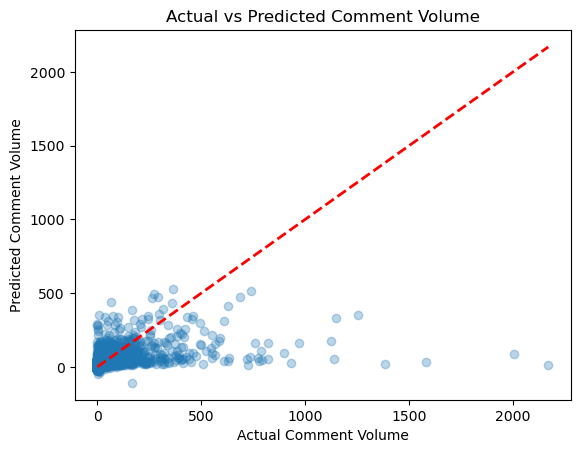

In [212]:
visualize(preprocess_y_test, preprocess_y_pred)

#### Option 3: Apply data preprocessing and feature engineering from WithoutMethods.ipynb

In [213]:
features_data = pd.read_pickle('raw_features.pkl')

In [214]:
# separate features and target
features_X = data.drop(columns=["Target_Comment_Volume"])
features_y = data["Target_Comment_Volume"]

# scale features
scaler = StandardScaler()
features_X_scaled = scaler.fit_transform(features_X)  # scale before splitting train-test so that all values are in the same range

In [215]:
features_X_train, features_X_test, features_y_train, features_y_test = train_test_split(features_X_scaled, features_y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each runX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each run

In [216]:
features_lin_regression = LinearRegression()
features_lin_regression.fit(features_X_train, features_y_train)  # lec 4, slide 46 - uses normal equations since we have a small/medium-sized dataset

LinearRegression()

In [217]:
features_y_pred = test(features_lin_regression, features_X_test, features_y_test)

Root mean Squared Error: 20.9389
Mean absolute Error: 5.7224
Mean Squared Error: 438.44
Median absolute Error: 2.2885
R² Score: 0.5812
sMAPE: 148.8794


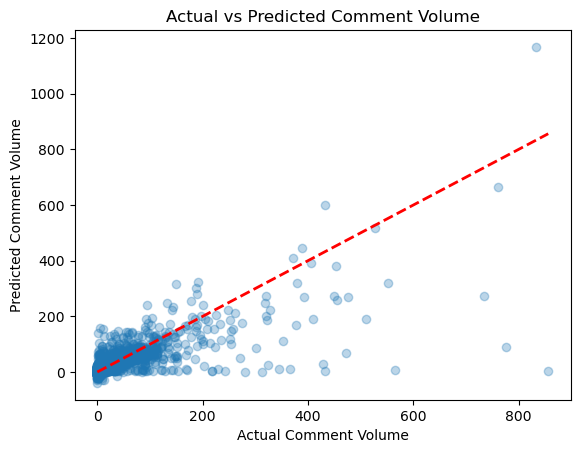

In [218]:
visualize(features_y_test, features_y_pred)

#### Option 4: Apply L2 (ridge) regularization

In [219]:
l2_data = pd.read_pickle('raw_features.pkl')

In [220]:
# separate features and target
l2_X = data.drop(columns=["Target_Comment_Volume"])
l2_y = data["Target_Comment_Volume"]

# scale features
scaler = StandardScaler()
l2_X_scaled = scaler.fit_transform(l2_X)  # scale before splitting train-test so that all values are in the same range

In [221]:
l2_X_train, l2_X_test, l2_y_train, l2_y_test = train_test_split(l2_X_scaled, l2_y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each runX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each run

In [222]:
l2 = Ridge()
l2.fit(l2_X_train, l2_y_train)

Ridge()

In [223]:
l2_y_pred = test(l2, l2_X_test, l2_y_test)

Root mean Squared Error: 20.9498
Mean absolute Error: 5.7162
Mean Squared Error: 438.90
Median absolute Error: 2.3057
R² Score: 0.5808
sMAPE: 148.8045


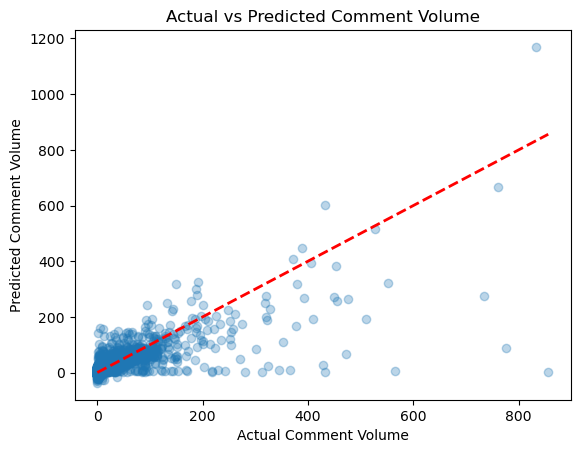

In [224]:
visualize(l2_y_test, l2_y_pred)

#### Option 5: Apply PCA with cross-validation on Linear regression and L2 regularization

In [225]:
pca_data = pd.read_pickle('raw_features.pkl')

In [226]:
# separate features and target
pca_X = data.drop(columns=["Target_Comment_Volume"])
pca_y = data["Target_Comment_Volume"]

# scale features
scaler = StandardScaler()
pca_X_scaled = scaler.fit_transform(pca_X)  # scale before splitting train-test so that all values are in the same range

In [227]:
model_train_flag = "Ridge" # either LinReg or Ridge

In [228]:
# PCA
pca = PCA(n_components=0.95)  # retain 95% variances

if model_train_flag == "LinReg":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', LinearRegression())
    ])
elif model_train_flag == "Ridge":
    pipeline = Pipeline([
        ('pca', pca),
        ('reg', Ridge(alpha=10))
    ])

In [229]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_X_scaled, pca_y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each runX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)  # setting random_state allows for the same split on each run

In [230]:
# fit pipeline
pipeline.fit(pca_X_train, pca_y_train)
pca_y_pred = pipeline.predict(pca_X_test)

In [231]:
# evaluation
print(f"{model_train_flag} Regression with PCA Results")
print(f"Train R²: {pipeline.score(pca_X_train, pca_y_train):.4f}")
print(f"Test R²: {pipeline.score(pca_X_test, pca_y_test):.4f}")

Ridge Regression with PCA Results
Train R²: 0.5391
Test R²: 0.5727


In [232]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, pca_X_scaled, pca_y, scoring='r2', cv=cv)
print("Cross-Validation R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))

Cross-Validation R² scores: [0.59747749 0.63120541 0.40727803 0.64696614 0.46545728]
Average R²: 0.5496768695074927


In [233]:
test(pipeline, pca_X_test, pca_y_test, pca_y_pred)

Root mean Squared Error: 21.1506
Mean absolute Error: 5.6223
Mean Squared Error: 447.35
Median absolute Error: 2.3361
R² Score: 0.5727
sMAPE: 147.3147


array([ 3.4029411 , -2.20676054,  5.32145178, ...,  9.546657  ,
        8.84082246,  2.45269806])

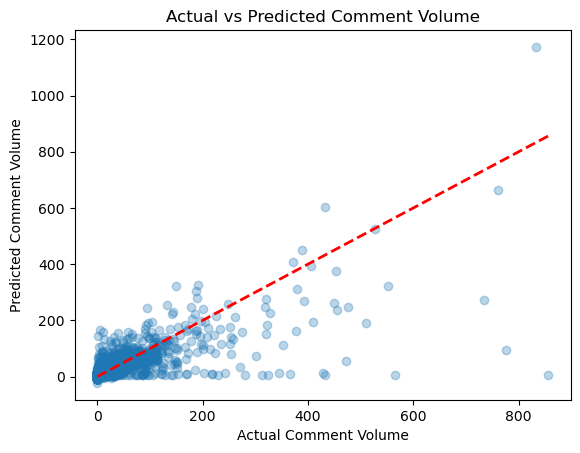

In [234]:
visualize(pca_y_test, pca_y_pred)

#### Results

LinReg Regression with PCA Results

Train R²: 0.5391

Test R²: 0.5727

Cross-Validation R² scores: [0.59746675 0.63116565 0.40724729 0.64698382 0.46549361]

Average R²: 0.5496714268656477

Root mean Squared Error: 21.1513

Mean absolute Error: 5.6218

Mean Squared Error: 447.38

Median absolute Error: 2.3353

R² Score: 0.5727

sMAPE: 147.3122

Ridge Regression with PCA Results

Train R²: 0.5391

Test R²: 0.5727

Cross-Validation R² scores: [0.59747749 0.63120541 0.40727803 0.64696614 0.46545728]

Average R²: 0.5496768695074927

Root mean Squared Error: 21.1506

Mean absolute Error: 5.6223

Mean Squared Error: 447.35

Median absolute Error: 2.3361

R² Score: 0.5727

sMAPE: 147.3147


#### Option 6: Apply autoencoder from DataPreprocessing.ipynb

In [235]:
auto_data = pd.read_pickle('raw_features.pkl')

In [236]:
# separate features and target
auto_X = data.drop(columns=["Target_Comment_Volume"])
auto_y = data["Target_Comment_Volume"]

# scale features
scaler = StandardScaler()
auto_X_scaled = scaler.fit_transform(auto_X)  # scale before splitting train-test so that all values are in the same range

In [ ]:
input_dim = auto_X_scaled.shape[1]
encoding_dim = 32 # Dimension of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(auto_X_scaled, auto_X_scaled, epochs=50, batch_size=32, verbose=0)

# Encode features
X_encoded = encoder.predict(auto_X_scaled)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, auto_y, test_size=0.3, random_state=42)

In [ ]:
# Linear Regression
auto_lr = LinearRegression()
auto_lr.fit(X_train_enc, y_train_enc)

In [ ]:
print("<----Linear Regression after autoencoder---->")
y_pred_enc = test(auto_lr, X_test_enc, y_test_enc)

In [ ]:
visualize(y_test_enc, y_pred_enc)

## Other Experiments
#### 1. Removing of outliers
results of test: (Train R² / Test R² / MSE / RMSE)

a) no outlier removal: model fits well, but affected by large outliers (0.56, 0.53, 467.04, 21.61)

b) remove x and y outliers: low error, but model trained on less data (0.32, 0.34, 1.72, 1.31) 

c) clip only the target value: balanced — outliers controlled, full dataset used (0.49, 0.48, 3.91, 1.98)
##### Conclusion: Clipping only the target value when removing outliers performed the best but not as well as other methods, removed to be able to compare metrics between models 

#### 2. Log transform target value
##### Conclusion: This resulted in very poor results and a negative r^2 value and so we opted to not log tranform the y-values 